# **Customer Segmentation**

# **Milestone 2**

**Note:** This is in continuation to the data preprocessing we did in Milestone 1. Results might differ if you have followed different steps in data preprocessing. 

## Preparing Data for Segmentation

### Dropping columns that we will not use for segmentation

The decision about which variables to use for clustering is a critically important decision that will have a big impact on the clustering solution. So we need to think carefully about the variables we will choose for clustering. Clearly, this is a step where a lot of contextual knowledge, creativity, and experimentation/iterations are needed.

Moreover, we often use only a few of the data attributes for segmentation (the segmentation attributes) and use some of the remaining ones (the profiling attributes) only to profile the clusters. For example, in market research and market segmentation, we can use behavioral data for segmentation (to segment the customers based on their behavior like amount spent, units bought, etc.), and then use both demographic as well as behavioral data for profiling the segments found.

Here, we will use the behavioral attributes for segmentation and drop the demographic attributes like Income, Age, and Family_Size. In addition to this, we need to drop some other columns which are mentioned below.

* `Dt_Customer`: We have created the `Engaged_in_days` variable using the Dt_Customer variable. Hence, we can drop this variable as it will not help with segmentation.
* `Complain`: About 95% of the customers didn't complain and have the same value for this column. This variable will not have a major impact on segmentation. Hence, we can drop this variable. 
* `day`:  We have created the `Engaged_in_days` variable using the 'day' variable. Hence, we can drop this variable as it will not help with segmentation.
* `Status`: This column was created just to get the `Family_Size` variable that contains the information about the Status. Hence, we can drop this variable.
* We also need to drop categorical variables like `Education` and `Marital_Status`, `Kids`, `Kidhome`, and `Teenhome` as distance-based algorithms cannot use the default distance like Euclidean to find the distance between categorical and numerical variables.
* We can also drop categorical variables like `AcceptedCmp1`, `AcceptedCmp2`, `AcceptedCmp3`, `AcceptedCmp4`, `AcceptedCmp5`, and `Response` for which we have create the variable `TotalAcceptedCmp` which is the aggregate of all these variables.

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To compute distances
from scipy.spatial.distance import cdist

# To perform K-means clustering and compute Silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To visualize the elbow curve and Silhouette scores
# from yellowbrick.cluster import SilhouetteVisualizer

# Importing PCA
from sklearn.decomposition import PCA

# To encode the variable
from sklearn.preprocessing import LabelEncoder

# Importing TSNE
from sklearn.manifold import TSNE

# To perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# To compute distances
from scipy.spatial.distance import pdist

# To import K-Medoids
# from sklearn_extra.cluster import KMedoids

# To import Gaussian Mixture
from sklearn.mixture import GaussianMixture

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("data.csv")

In [5]:
# Dropping all the irrelevant columns and storing in data_model
data_model = data.drop(
    columns=[
        "Year_Birth",
        "Dt_Customer",
        "day",
        "Complain",
        "Response",
        "AcceptedCmp1",
        "AcceptedCmp2",
        "AcceptedCmp3",
        "AcceptedCmp4",
        "AcceptedCmp5",
        "Marital_Status",
        "Status",
        "Kids",
        'Education',
        'Kidhome',
        'Teenhome', 'Income','Age', 'Family_Size'
    ],
    axis=1,
)

In [7]:
# Check the shape of new data 
data.shape

(2227, 36)

In [8]:
# Check first five rows of new data
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,day,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
0,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,88,...,59,0,1,1,1617,25,2015-01-01,997,1,64.680000
1,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,1,...,62,2,1,3,27,6,2015-01-01,151,0,4.500000
2,1965,Graduation,Relationship,71613.0,0,0,2013-08-21,26,426,49,...,51,0,2,2,776,21,2015-01-01,498,0,36.952381
3,1984,Graduation,Relationship,26646.0,1,0,2014-10-02,26,11,4,...,32,1,2,3,53,8,2015-01-01,91,0,6.625000
4,1981,PhD,Relationship,58293.0,1,0,2014-01-19,94,173,43,...,35,1,2,3,422,19,2015-01-01,347,0,22.210526


**Let's plot the correlation plot after we've removed the irrelevant variables.**

In [9]:
# Plot the correlation plot for new data
data.corr()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Response,Age,Kids,Status,Family_Size,Expenses,NumTotalPurchases,Engaged_in_days,TotalAcceptedCmp,AmountPerPurchase
Year_Birth,1.000000,-0.211914,0.234287,-0.364301,-0.018149,-0.162688,-0.013358,-0.038422,-0.042066,-0.018937,...,0.018924,-1.000000,-0.096080,-0.001449,-0.080420,-0.116140,-0.185013,0.021778,0.007075,-0.046786
Income,-0.211914,1.000000,-0.528643,0.040388,0.005867,0.728320,0.535365,0.694043,0.550074,0.549860,...,0.174128,0.211914,-0.349396,-0.015144,-0.297656,0.820486,0.695995,-0.032276,0.364110,0.487375
Kidhome,0.234287,-0.528643,1.000000,-0.036404,0.008666,-0.498523,-0.373718,-0.443464,-0.388808,-0.371877,...,-0.080513,-0.234287,0.689902,0.023755,0.584494,-0.557371,-0.480776,-0.058220,-0.193973,-0.358130
Teenhome,-0.364301,0.040388,-0.036404,1.000000,0.015935,0.003149,-0.177763,-0.267845,-0.205992,-0.164297,...,-0.156150,0.364301,0.698308,0.030520,0.595033,-0.139743,0.132814,0.007748,-0.160545,-0.138725
Recency,-0.018149,0.005867,0.008666,0.015935,1.000000,0.016497,-0.003597,0.026406,0.001466,0.022854,...,-0.199286,0.018149,0.017750,-0.003274,0.012988,0.021848,0.006927,0.032273,-0.090200,0.012920
MntWines,-0.162688,0.728320,-0.498523,0.003149,0.016497,1.000000,0.387288,0.585911,0.397702,0.384568,...,0.246304,0.162688,-0.354798,-0.007286,-0.297987,0.895839,0.720182,0.147679,0.489406,0.504485
MntFruits,-0.013358,0.535365,-0.373718,-0.177763,-0.003597,0.387288,1.000000,0.562560,0.593784,0.566381,...,0.124984,0.013358,-0.396452,-0.026197,-0.342500,0.615259,0.459726,0.059198,0.171407,0.360031
MntMeatProducts,-0.038422,0.694043,-0.443464,-0.267845,0.026406,0.585911,0.562560,1.000000,0.589627,0.544148,...,0.246902,0.038422,-0.511663,-0.028947,-0.439466,0.853360,0.548333,0.070015,0.342823,0.622484
MntFishProducts,-0.042066,0.550074,-0.388808,-0.205992,0.001466,0.397702,0.593784,0.589627,1.000000,0.578814,...,0.110385,0.042066,-0.427709,-0.018104,-0.364143,0.644700,0.473314,0.077067,0.179147,0.379950
MntSweetProducts,-0.018937,0.549860,-0.371877,-0.164297,0.022854,0.384568,0.566381,0.544148,0.578814,1.000000,...,0.116329,0.018937,-0.385379,-0.020222,-0.330167,0.604963,0.477019,0.076605,0.198387,0.345816


**Observations and Insights:**

### Scaling the Data

**What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like Age, Income, and Amount related variables, with their range as (18–100 Years), (25K–75K), and (100–200), respectively, feature scaling would help them all to be in the same range.

**Why feature scaling is important in Unsupervised Learning?**

Feature scaling is especially relevant in machine learning models that compute some sort of distance metric as we do in most clustering algorithms, for example, K-Means. 

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

**Let's scale the data**

**Standard Scaler**: StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

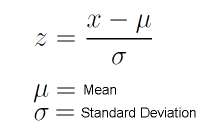

1. Data standardization is the process of rescaling the attributes so that they have a mean of 0 and a variance of 1.
2. The ultimate goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values.
3. In sklearn.preprocessing.StandardScaler(), centering and scaling happen independently on each feature.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2227 non-null   int64  
 1   Education            2227 non-null   object 
 2   Marital_Status       2227 non-null   object 
 3   Income               2227 non-null   float64
 4   Kidhome              2227 non-null   int64  
 5   Teenhome             2227 non-null   int64  
 6   Dt_Customer          2227 non-null   object 
 7   Recency              2227 non-null   int64  
 8   MntWines             2227 non-null   int64  
 9   MntFruits            2227 non-null   int64  
 10  MntMeatProducts      2227 non-null   int64  
 11  MntFishProducts      2227 non-null   int64  
 12  MntSweetProducts     2227 non-null   int64  
 13  MntGoldProds         2227 non-null   int64  
 14  NumDealsPurchases    2227 non-null   int64  
 15  NumWebPurchases      2227 non-null   i

In [15]:
# create a list of categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Education', 'Marital_Status', 'Dt_Customer', 'day']

In [16]:
# create a list of numerical columns
numerical_cols = data.select_dtypes(exclude=['object']).columns.tolist()
numerical_cols

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response',
 'Age',
 'Kids',
 'Status',
 'Family_Size',
 'Expenses',
 'NumTotalPurchases',
 'Engaged_in_days',
 'TotalAcceptedCmp',
 'AmountPerPurchase']

In [18]:
#data[numerical_cols].head()

In [19]:
# Applying standard scaler on new data numerical columns
scaler = StandardScaler()                                                   # Initialize the Standard Scaler

df_scaled = scaler.fit_transform(data[numerical_cols])                                     # fit_transform the scaler function on new data

df_scaled = pd.DataFrame(df_scaled, columns=data_model.columns)      # Converting the embeddings to a dataframe

df_scaled.head()

ValueError: Shape of passed values is (2227, 32), indices imply (2227, 17)

In [10]:
# Applying standard scaler on new data
scaler = StandardScaler()                                                   # Initialize the Standard Scaler

df_scaled = scaler.fit_transform(data)                                     # fit_transform the scaler function on new data

df_scaled = pd.DataFrame(df_scaled, columns=data_model.columns)      # Converting the embeddings to a dataframe

df_scaled.head()

ValueError: could not convert string to float: 'Graduation'

## **Applying T-SNE and PCA to the data to visualize the data distributed in 2 dimensions**

### **Applying T-SNE**

In [ ]:
# Fitting T-SNE with number of components equal to 2 to visualize how data is distributed

tsne = _____________        # Initializing T-SNE with number of component equal to 2, random_state=1, and perplexity=35

data_air_pol_tsne = ___________                            # fit_transform T-SNE on new data

data_air_pol_tsne = pd.DataFrame(data_air_pol_tsne, columns=[0, 1])           # Converting the embeddings to a dataframe

plt.figure(figsize=(7, 7))                                                    # Scatter plot for two components

sns.scatterplot(x=0, y=1, data=data_air_pol_tsne)                             # Plotting T-SNE

**Observation and Insights:**

### **Applying PCA**

**Think about it:**
- Should we apply clustering algorithms on the current data or should we apply PCA on the data before applying clustering algorithms? How would this help?

When the variables used in clustering are highly correlated, it causes multicollinearity, which affects the clustering method and results in poor cluster profiling (or biased toward a few variables). PCA can be used to reduce the multicollinearity between the variables. 

In [70]:
# Defining the number of principal components to generate
n = data_model.shape[1]                                        # Storing the number of variables in the data

pca = _________________                                        # Initialize PCA with n_components = n and random_state=1

data_pca = pd.DataFrame(pca.____________)                      # fit_transform PCA on the scaled data

# The percentage of variance explained by each principal component is stored
exp_var = pca.explained_variance_ratio_                     

**Let's plot the first two components and see how the data points are distributed.**

In [ ]:
# Scatter plot for two components using the dataframe data_pca
____________

**Let's apply clustering algorithms on the data generated after applying PCA**

## **K-Means** 

In [72]:
distortions = []                                                  # Create an empty list

K = range(2, 10)                                                  # Setting the K range from 2 to 10

for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=4)              # Initialize K-Means
    kmeanModel.fit(data_pca)                                      # Fit K-Means on the data
    distortions.append(kmeanModel.inertia_)                       # Append distortion values to the empty list created above

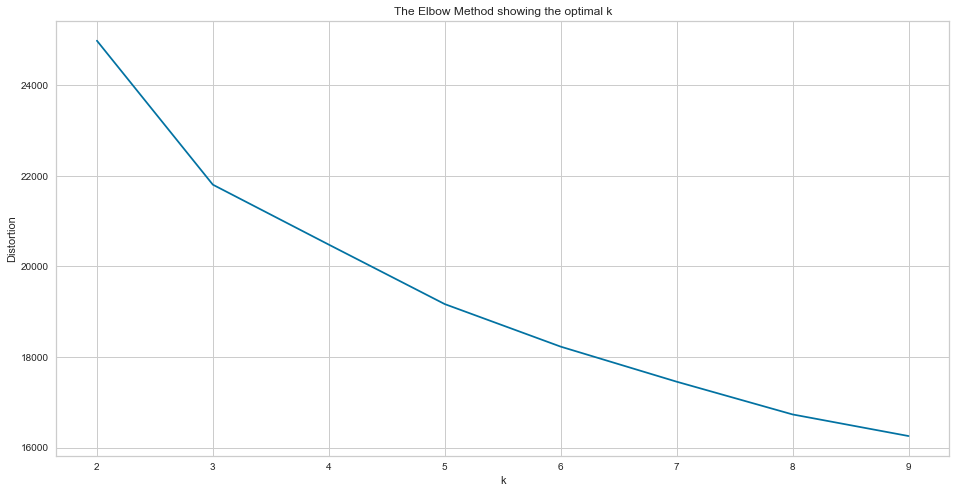

In [73]:
# Plotting the elbow plot
plt.figure(figsize=(16, 8))                                            # Setting the plot size

plt.plot(K, distortions, "bx-")                                        # Plotting the K on X-axis and distortions on y-axis

plt.xlabel("k")                                                        # Title of x-axis

plt.ylabel("Distortion")                                               # Title of y-axis

plt.title("The Elbow Method showing the optimal k")                    # Title of the plot
plt.show()

**In the above plot, the elbow is seen for K=3 and K=5 as there is some drop in distortion at K=3 and K=5.**

**Think About It:**

- How do we determine the optimal K value when the elbows are observed at 2 or more K values from the elbow curve?
- Which metric can be used to determine the final K value?

**We can use the silhouette score as a metric for different K values to make a better decision about picking the number of clusters(K).**

### **What is the silhouette score?**

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the clusters are dense and well separated, which is good.
* Silhouette score near -1 indicates that those samples might have been assigned to the wrong cluster.

**Finding silhouette score for each value of K**

In [ ]:
sil_score = []                                                             # Creating empty list
cluster_list = range(3, 7)                                                 # Creating a range from 3 to 7
for n_clusters in cluster_list:
    
    # Initialize K-Means with number of clusters equal to n_clusters and random_state=1
    clusterer = _______________
    
    # Fit and predict on the pca data
    preds = clusterer._________ 
    
    # Calculate silhouette score - Hint: Use silhouette_score() function
    score = ___________  
    
    # Append silhouette score to empty list created above
    __________         
    
    # Print the silhouette score
    print( "For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))  

**From the above silhouette scores, 3 appears to be a good value of K. So, let's build K-Means using K=3.**

### **Applying K-Means on data_pca**

In [ ]:
kmeans = _____________                                # Initialize the K-Means algorithm with 3 clusters and random_state=1

kmeans.__________                                     # Fitting on the data_pca

In [76]:
data_pca["K_means_segments_3"] = kmeans.labels_                    # Adding K-Means cluster labels to the data_pca data

data["K_means_segments_3"] = kmeans.labels_                        # Adding K-Means cluster labels to the whole data

data_model["K_means_segments_3"] = kmeans.labels_                  # Adding K-Means cluster labels to data_model

In [ ]:
# Let's check the distribution
data_model["K_means_segments_3"]._________

**Let's visualize the clusters using PCA**

In [78]:
# Function to visualize PCA data with clusters formed
def PCA_PLOT(X, Y, PCA, cluster):
    sns.scatterplot(x=X, y=1, data=PCA, hue=cluster)

In [ ]:
PCA_PLOT(0, 1, data_pca, "K_means_segments_3")

**Observations and Insights:**

### **Cluster Profiling**

In [80]:
# Taking the cluster-wise mean of all the variables. Hint: First groupby 'data' by 'K_means_segments_3' and then find mean
cluster_profile_KMeans_3 = _____________

In [ ]:
# Highlighting the maximum average value among all the clusters for each of the variables
cluster_profile_KMeans_3.style.highlight_max(color="lightgreen", axis=0)

**Observations and Insights:**

**Let us create a boxplot for each of the variables**

In [82]:
# Columns to use in boxplot
col_for_box = ['Income','Kidhome','Teenhome','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Age','Family_Size','Expenses','NumTotalPurchases','Engaged_in_days','TotalAcceptedCmp','AmountPerPurchase']

In [ ]:
# Creating boxplot for each of the variables
all_col = col_for_box

plt.figure(figsize = (30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(6, 4, i + 1)
    
    sns.__________(y=data[variable], x=data['K_means_segments_3'],showmeans=True)
    
    plt.tight_layout()
    
    plt.title(variable)

plt.show()

### **Characteristics of each cluster:**



**Cluster 0:__________**

**Summary for cluster 0:_______________** 

**Cluster 1:_______________**

**Summary for cluster 1:_______________**



**Cluster 2:_______________** 

**Summary for cluster 2:_______________**

**Think About It:**
- Are the K-Means profiles with K=3 providing any deep insights into customer purchasing behavior or which channels they are using?
- What is the next step to get more meaningful insights? 

We can see from the above profiles that K=3 segments the customers into High, Medium and Low-income customers, and we are not getting deep insights into different types of customers. So, let's try to build K=5 (which has another elbow in the Elbow curve) and see if we can get better cluster profiles.

In [ ]:
# Dropping labels we got from K=3 since we will be using PCA data for prediction
# Drop K_means_segments_3. Hint: Use axis=1 and inplace=True
data_pca._______
data._______

**Let's build K-Means using K=5**

In [ ]:
# Fit the K-Means algorithm using number of cluster as 5 and random_state=0 on data_pca


In [86]:
# Add K-Means cluster labels to data_pca

# Add K-Means cluster labels to whole data

# Add K-Means cluster labels to data_model


In [ ]:
# Let's check the distribution


**Let's visualize the clusters using PCA**

In [ ]:
# Hint: Use PCA_PLOT function created above


### **Cluster Profiling**

In [89]:
# Take the cluster-wise mean of all the variables. Hint: First groupby 'data' by cluster labels column and then find mean


In [ ]:
# Highlight the maximum average value among all the clusters for each of the variables

**Let's plot the boxplot**

In [ ]:
# Create boxplot for each of the variables


### **Characteristics of each cluster**

**Cluster 0:__________**

**Summary for cluster 0:_______________** 

**Cluster 1:_______________**

**Summary for cluster 1:_______________**


**Cluster 2:_______________** 

**Summary for cluster 2:_______________**

**Cluster 3:_______________** 

**Summary for cluster 3:_______________**

**Cluster 4:_______________** 

**Summary for cluster 4:_______________**

In [ ]:
# Dropping labels we got from K-Means since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca._____________
data.____________

From the above profiles, K=5 provides more interesting insights about customer's purchasing behavior and preferred channels for purchasing products. We can also see that the High, Medium and Low income groups have different age groups and preferences, which was not evident in K=3. So, **we can choose K=5.**

## **K-Medoids**

**Let's find the silhouette score for K=5 in K-Medoids**

In [ ]:
kmedo = ____________           # Initializing K-Medoids with number of clusters as 5 and random_state=1

preds = ___________            # Fit and predict K-Medoids using data_pca

score = ____________           # Calculate the silhouette score

print(score)                   # Print the score

**Observations and Insights:**

In [91]:
# Predicting on data_pca and ddding K-Medoids cluster labels to the whole data

# Predicting on data_pca and ddding K-Medoids cluster labels to data_model

# Predicting on data_pca and ddding K-Medoids cluster labels to data_pca


In [ ]:
# Let's check the distribution


**Let's visualize the clusters using PCA**

In [ ]:
# Hint: Use PCA_PLOT function created above


### **Cluster Profiling**

In [125]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean


In [ ]:
# Highlight the maximum average value among all the clusters for each of the variables


**Let's plot the boxplot**

In [ ]:
# Create boxplot for each of the variables


### **Characteristics of each cluster**

**Cluster 0:__________**

**Summary for cluster 0:_______________** 

**Cluster 1:_______________**

**Summary for cluster 1:_______________**


**Cluster 2:_______________** 

**Summary for cluster 2:_______________**

**Cluster 3:_______________** 

**Summary for cluster 3:_______________**

**Cluster 4:_______________** 

**Summary for cluster 4:_______________**

In [94]:
# Dropping labels we got from K-Medoids since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca._____________
data.____________

## **Hierarchical Clustering**

Let's find the Cophenetic correlation for different distances with different linkage methods.

### **What is a Cophenetic correlation?**

The cophenetic correlation coefficient is a correlation coefficient between the cophenetic distances(Dendrogramic distance) obtained from the tree, and the original distances used to construct the tree. It is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points. 

The cophenetic distance between two observations is represented in a dendrogram by the height of the link at which those two observations are first joined. That height is the distance between the two subclusters that are merged by that link.

Cophenetic correlation is the way to compare two or more dendrograms. 

**Let's calculate Cophenetic correlation for each of the distance metrics with each of the linkage methods**

In [ ]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average"]

high_cophenet_corr = 0                                                 # Creating a variable by assigning 0 to it
high_dm_lm = [0, 0]                                                    # Creating a list by assigning 0's to it

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(data_pca, metric=dm, method=lm)                    # Applying different linkages with different distance on data_pca
        c, coph_dists = cophenet(Z, pdist(data_pca))                   # Calculating cophenetic correlation
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:                                     # Checking if cophenetic correlation is higher than previous score
            high_cophenet_corr = c                                     # Appending to high_cophenet_corr list if it is higher
            high_dm_lm[0] = dm                                         # Appending its corresponding distance
            high_dm_lm[1] = lm                                         # Appending its corresponding method or linkage

In [ ]:
# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

**Let's have a look at the dendrograms for different linkages with `Cityblock distance`**

In [ ]:
# List of linkage methods
linkage_methods = ["single", "complete", "average"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# To create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))            # Setting the plot size

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(data_pca, metric="Cityblock", method=method)                  # Measures the distances between two clusters

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")           # Title of dendrogram

    coph_corr, coph_dist = cophenet(Z, pdist(data_pca))                       # Finding cophenetic correlation for different linkages with city block distance
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations and Insights:**

**Think about it:**

- Can we clearly decide the number of clusters based on where to cut the dendrogram horizontally?
- What is the next step in obtaining number of clusters based on the dendrogram?

**Let's have a look at the dendrograms for different linkages with `Chebyshev distance`**

In [ ]:
# Plot the dendrogram for Chebyshev distance with linkages single, complete and average. 
# Hint: Use Chebyshev distance as the metric in the linkage() function 


**Observations and Insights:**

**Let's have a look at the dendrograms for different linkages with Mahalanobis distance**

In [ ]:
# Plot the dendrogram for Mahalanobis distance with linkages single, complete and average. 
# Hint: Use Mahalanobis distance as the metric in the linkage() function 


**Observations and Insights:**

**Let's have a look at the dendrograms for different linkages with Euclidean distance**

In [ ]:
# Plot the dendrogram for Euclidean distance with linkages single, complete, average and ward. 
# Hint: Use Euclidean distance as the metric in the linkage() function 


**Think about it:**

- Are there any distinct clusters in any of the dendrograms?

**Observations and Insights:**

In [ ]:
# Initialize Agglomerative Clustering with affinity (distance) as Euclidean, linkage as 'Ward' with clusters=3
HCmodel = AgglomerativeClustering(n_clusters=______, affinity=______, linkage=______,) 

# Fit on data_pca
HCmodel.__________                                                                  

In [96]:
# Add Agglomerative Clustering cluster labels to data_pca

# Add Agglomerative Clustering cluster labels to the whole data

# Add Agglomerative Clustering cluster labels to data_model

In [ ]:
# Let's check the distribution


**Let's visualize the clusters using PCA.**

In [ ]:
# Hint: Use PCA_PLOT function created above


### **Cluster Profiling**

In [ ]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean


In [ ]:
# Highlight the maximum average value among all the clusters for each of the variables


**Let's plot the boxplot**

In [ ]:
# Create boxplot for each of the variables


### **Characteristics of each cluster**

**Cluster 0:__________**

**Summary for cluster 0:_______________** 

**Cluster 1:_______________**

**Summary for cluster 1:_______________**


**Cluster 2:_______________** 

**Summary for cluster 2:_______________**

**Observations and Insights:**

In [ ]:
# Dropping labels we got from Agglomerative Clustering since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca._____________
data.____________

## **DBSCAN**

DBSCAN is a very powerful algorithm for finding high-density clusters, but the problem is determining the best set of hyperparameters to use with it. It includes two hyperparameters, `eps`, and `min samples`.

Since it is an unsupervised algorithm, you have no control over it, unlike a supervised learning algorithm, which allows you to test your algorithm on a validation set. The approach we can follow is basically trying out a bunch of different combinations of values and finding the silhouette score for each of them.

In [ ]:
# Initializing lists
eps_value = [2,3]                       # Taking random eps value
min_sample_values = [6,20]              # Taking random min_sample value

# Creating a dictionary for each of the values in eps_value with min_sample_values
res = {eps_value[i]: min_sample_values for i in range(len(eps_value))}  

In [ ]:
# Finding the silhouette_score for each of the combinations
high_silhouette_avg = 0                                               # Assigning 0 to the high_silhouette_avg variable
high_i_j = [0, 0]                                                     # Assigning 0's to the high_i_j list
key = res.keys()                                                      # Assigning dictionary keys to a variable called key
for i in key:
    z = res[i]                                                        # Assigning dictionary values of each i to z
    for j in z:
        db = DBSCAN(eps=i, min_samples=j).fit(data_pca)               # Applying DBSCAN to each of the combination in dictionary
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        silhouette_avg = silhouette_score(data_pca, labels)           # Finding silhouette score 
        print( 
            "For eps value =" + str(i),
            "For min sample =" + str(j),
            "The average silhoutte_score is :",
            silhouette_avg,                                          # Printing the silhouette score for each of the combinations
        )
        if high_silhouette_avg < silhouette_avg:                     # If the silhouette score is greater than 0 or the previous score, it will get appended to the high_silhouette_avg list with its combination of i and j              
            high_i_j[0] = i
            high_i_j[1] = j

In [ ]:
# Printing the highest silhouette score
print("Highest_silhoutte_avg is {} for eps = {} and min sample = {}".format(high_silhouette_avg, high_i_j[0], high_i_j[1]))

**Now, let's apply DBSCAN using the hyperparameter values we have received above.**

In [ ]:
# Apply DBSCAN using the above hyperparameter values
dbs = _____________________

In [ ]:
# fit_predict on data_pca and add DBSCAN cluster labels to the whole data

# fit_predict on data_pca and add DBSCAN cluster labels to data_model

# fit_predict on data_pca and add DBSCAN cluster labels to data_pca

In [ ]:
# Let's check the distribution


**Let's visualize the clusters using PCA.**

In [ ]:
# Hint: Use PCA_PLOT function created above


**Observations and Insights:**

**Think about it:**

- Changing the eps and min sample values will result in different DBSCAN results? Can we try more value for eps and min_sample?

**Note:** You can experiment with different eps and min_sample values to see if DBSCAN produces good distribution and cluster profiles.

In [148]:
# Dropping labels we got from DBSCAN since we will be using PCA data for prediction
# Hint: Use axis=1 and inplace=True
data_pca._____________
data.____________

## **Gaussian Mixture Model**

**Let's find the silhouette score for K=5 in Gaussian Mixture**

In [ ]:
gmm = GaussianMixture(_______) # Initialize Gaussian Mixture Model with number of clusters as 5 and random_state=1

preds = ___________            # Fit and predict Gaussian Mixture Model using data_pca

score = ____________           # Calculate the silhouette score

print(score)                   # Print the score

**Observations and Insights:**

In [ ]:
# Predicting on data_pca and add Gaussian Mixture Model cluster labels to the whole data

# Predicting on data_pca and add Gaussian Mixture Model cluster labels to data_model

# Predicting on data_pca and add Gaussian Mixture Model cluster labels to data_pca


In [ ]:
# Let's check the distribution


**Let's visualize the clusters using PCA.**

In [ ]:
# Hint: Use PCA_PLOT function created above


### **Cluster Profiling**

In [ ]:
# Take the cluster-wise mean of all the variables. Hint: First group 'data' by cluster labels column and then find mean


In [ ]:
# Highlight the maximum average value among all the clusters for each of the variables


**Let's plot the boxplot**

In [ ]:
# Create boxplot for each of the variables


### **Characteristics of each cluster**

**Cluster 0:__________**

**Summary for cluster 0:_______________** 

**Cluster 1:_______________**

**Summary for cluster 1:_______________**


**Cluster 2:_______________** 

**Summary for cluster 2:_______________**

**Cluster 3:_______________** 

**Summary for cluster 3:_______________**

**Cluster 4:_______________** 

**Summary for cluster 4:_______________**

## **Conclusion and Recommendations**

- **Refined Insights:** What are the most meaningful insights from the data relevant to the problem?

- **Comparison of various techniques and their relative performance:** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- **Proposal for the final solution design:** What model do you propose to be adopted? Why is this the best solution to adopt?